In [1]:
import cv2
from ultralytics import YOLO
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
video = 'videos/rl-truck.mp4'
model = YOLO('yolov8n.pt')

cap = cv2.VideoCapture(video)
history = defaultdict(lambda: [])

In [3]:
while cap.isOpened:
    ret, frame = cap.read()
    if ret:

        results = model.track(frame, persist=True)

        if results[0].boxes.id is None:
            continue

        boxes = results[0].boxes.xywh.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        annotation = results[0].plot()

        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box
            track = history[track_id]
            track.append((float(x), float(y)))
            if len(track) > 120:
                track.pop(0)

            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotation, [points], isClosed=False, color=(
                230, 230, 230), thickness=5)

        cv2.imshow("Stream: ", annotation)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:  # end of video
        break

cap.release()
cv2.destroyAllWindows()


0: 384x640 3 airplanes, 1 kite, 168.5ms
Speed: 11.8ms preprocess, 168.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 airplanes, 1 kite, 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 airplanes, 1 kite, 129.3ms
Speed: 3.0ms preprocess, 129.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 airplane, 129.4ms
Speed: 3.3ms preprocess, 129.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 airplane, 125.0ms
Speed: 2.0ms preprocess, 125.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 airplane, 120.8ms
Speed: 3.0ms preprocess, 120.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 airplane, 120.4ms
Speed: 2.0ms preprocess, 120.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 airplane, 123.5ms
Speed: 3.0ms preprocess, 123.5

[array([     235.29,      236.04,      236.28,      239.12,      239.25,      242.05,      242.32,      242.39,      243.86,      244.39,      246.89,      247.01,      247.03,      249.41,      250.28,      251.88,      252.44,      252.62,      254.34,      254.95,      256.94,      257.66,      257.89,      258.84,
            259.16,      262.34,       263.5,      263.89,      264.95,      265.31,      266.26,      266.57,      266.64,      267.82,      268.24,       268.2,       268.9,      269.13,      269.46,      269.56,      269.92,      270.05,      270.07,      270.11,      270.12,      271.53,      272.08,      294.68,
            295.15,      295.29,       297.4,      298.62,      301.52,       302.6,      302.97,      307.26,      308.86,      312.33,       313.6,      314.03,      317.05,      318.15,      322.46,      324.09,      324.63,      329.12,      330.78,      335.88,      337.74,      338.38,      343.04,      344.75,
            350.89,      353.12,      353.

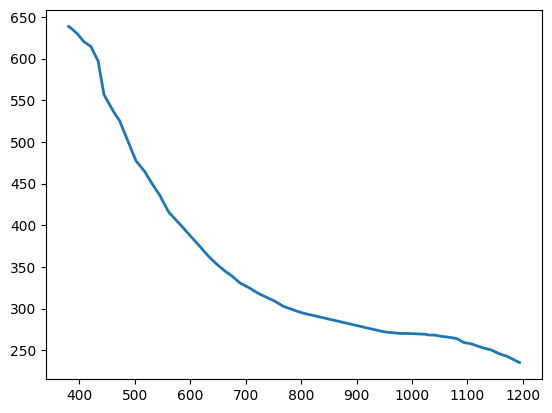

In [4]:
if history:
    fig, ax = plt.subplots()
    # print(history[1])
    # trajectory = np.array(history[1])
    # print(trajectory)
    # ax.plot(trajectory[:, 0], trajectory[:, 1], linewidth=2)
    numpy_history = []
    for track_id, points in history.items():
        points = np.array(points)
        ax.plot(points[:, 0], points[:, 1], linewidth=2)
        numpy_history.append(points)
    # print(numpy_history)
    x_points = [point[:, 0] for point in numpy_history]
    y_points = [point[:, 1] for point in numpy_history]
    print(y_points)
    print(x_points)
    plt.savefig('output_plot.png')

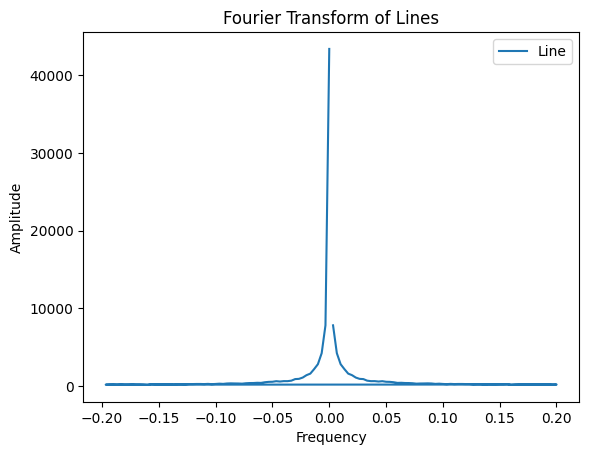

In [5]:
def fourier_transform(line):
    x, y = np.array(line)
    fft_result = np.fft.fft(y)

    freq = np.fft.fftfreq(len(fft_result), d=(x[1]- x[0]))
    return freq, fft_result

for line in zip(x_points, y_points):
    freq, fft_result = fourier_transform(line)
    plt.plot(freq, np.abs(fft_result), label="Line")

plt.title("Fourier Transform of Lines")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

id: 0, (120, 1), mean_squared_error: 2810.0679079541305, r2_score: 0.807790193254941
impaired driving detected.


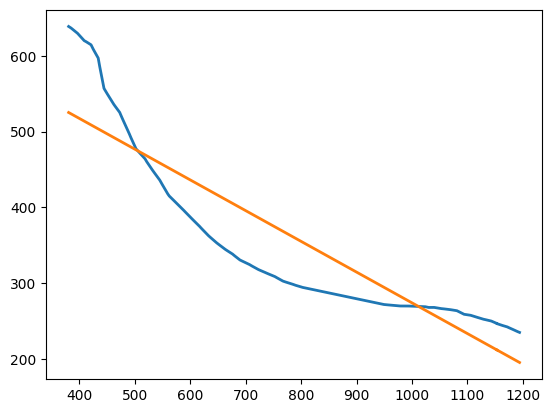

In [8]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regression = linear_model.LinearRegression()
car_regressions = []
for i, (x, y) in enumerate(zip(x_points, y_points)):
    stats = {}
    x = x.reshape(-1, 1)
    regression.fit(x, y)
    y_pred = regression.predict(x)
    stats['mean_squared_error'] = mean_squared_error(y, y_pred)
    stats['r2_score'] = r2_score(y, y_pred)
    stats['x_vals'] = x
    stats['y_vals'] = y
    stats['y_pred'] = y_pred
    stats['id'] = i
    car_regressions.append(stats)
    # print(stats)

fig, ax = plt.subplots()
car_regressions.sort(key=lambda x: x['mean_squared_error'])
car_reg = car_regressions[-1]
print(f"id: {i}, {car_reg['x_vals'].shape}, mean_squared_error: {car_reg['mean_squared_error']}, r2_score: {car_reg['r2_score']}")
ax.plot(car_reg['x_vals'], car_reg['y_vals'], linewidth=2)
ax.plot(car_reg['x_vals'], car_reg['y_pred'], linewidth=2)
if (car_reg['mean_squared_error'] > 2000):
    print("impaired driving detected.")